In [14]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output # Only for iPython

#Helper function

In [15]:
def crossMat(a):
    """
    Returns the cross product matrix of vector 'a'.

    Parameters:
    a : np.ndarray
        A 3-element array representing a vector.

    Returns:
    A : np.ndarray
        The cross product matrix corresponding to vector 'a'.
    """
    A = np.array([[0, -a[2], a[1]],
                  [a[2], 0, -a[0]],
                  [-a[1], a[0], 0]])

    return A

#Gradient and Hessian of elastic energies

In [16]:
def gradEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    """
    Returns the derivative of bending energy E_k^b with respect to
    x_{k-1}, y_{k-1}, x_k, y_k, x_{k+1}, and y_{k+1}.

    Parameters:
    xkm1, ykm1 : float
        Coordinates of the previous node (x_{k-1}, y_{k-1}).
    xk, yk : float
        Coordinates of the current node (x_k, y_k).
    xkp1, ykp1 : float
        Coordinates of the next node (x_{k+1}, y_{k+1}).
    curvature0 : float
        Discrete natural curvature at node (xk, yk).
    l_k : float
        Voronoi length of node (xk, yk).
    EI : float
        Bending stiffness.

    Returns:
    dF : np.ndarray
        Derivative of bending energy.
    """

    # Nodes in 3D
    node0 = np.array([xkm1, ykm1, 0.0])
    node1 = np.array([xk, yk, 0])
    node2 = np.array([xkp1, ykp1, 0])

    # Unit vectors along z-axis
    m2e = np.array([0, 0, 1])
    m2f = np.array([0, 0, 1])

    kappaBar = curvature0

    # Initialize gradient of curvature
    gradKappa = np.zeros(6)

    # Edge vectors
    ee = node1 - node0
    ef = node2 - node1

    # Norms of edge vectors
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)

    # Unit tangents
    te = ee / norm_e
    tf = ef / norm_f

    # Curvature binormal
    kb = 2.0 * np.cross(te, tf) / (1.0 + np.dot(te, tf))

    chi = 1.0 + np.dot(te, tf)
    tilde_t = (te + tf) / chi
    tilde_d2 = (m2e + m2f) / chi

    # Curvature
    kappa1 = kb[2]

    # Gradient of kappa1 with respect to edge vectors
    Dkappa1De = 1.0 / norm_e * (-kappa1 * tilde_t + np.cross(tf, tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (-kappa1 * tilde_t - np.cross(te, tilde_d2))

    # Populate the gradient of kappa
    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] = Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] = Dkappa1Df[0:2]

    # Gradient of bending energy
    dkappa = kappa1 - kappaBar
    dF = gradKappa * EI * dkappa / l_k

    return dF

In [17]:
def hessEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    """
    Returns the Hessian (second derivative) of bending energy E_k^b
    with respect to x_{k-1}, y_{k-1}, x_k, y_k, x_{k+1}, and y_{k+1}.

    Parameters:
    xkm1, ykm1 : float
        Coordinates of the previous node (x_{k-1}, y_{k-1}).
    xk, yk : float
        Coordinates of the current node (x_k, y_k).
    xkp1, ykp1 : float
        Coordinates of the next node (x_{k+1}, y_{k+1}).
    curvature0 : float
        Discrete natural curvature at node (xk, yk).
    l_k : float
        Voronoi length of node (xk, yk).
    EI : float
        Bending stiffness.

    Returns:
    dJ : np.ndarray
        Hessian of bending energy.
    """

    # Nodes in 3D
    node0 = np.array([xkm1, ykm1, 0])
    node1 = np.array([xk, yk, 0])
    node2 = np.array([xkp1, ykp1, 0])

    # Unit vectors along z-axis
    m2e = np.array([0, 0, 1])
    m2f = np.array([0, 0, 1])

    kappaBar = curvature0

    # Initialize gradient of curvature
    gradKappa = np.zeros(6)

    # Edge vectors
    ee = node1 - node0
    ef = node2 - node1

    # Norms of edge vectors
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)

    # Unit tangents
    te = ee / norm_e
    tf = ef / norm_f

    # Curvature binormal
    kb = 2.0 * np.cross(te, tf) / (1.0 + np.dot(te, tf))

    chi = 1.0 + np.dot(te, tf)
    tilde_t = (te + tf) / chi
    tilde_d2 = (m2e + m2f) / chi

    # Curvature
    kappa1 = kb[2]

    # Gradient of kappa1 with respect to edge vectors
    Dkappa1De = 1.0 / norm_e * (-kappa1 * tilde_t + np.cross(tf, tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (-kappa1 * tilde_t - np.cross(te, tilde_d2))

    # Populate the gradient of kappa
    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] = Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] = Dkappa1Df[0:2]

    # Compute the Hessian (second derivative of kappa)
    DDkappa1 = np.zeros((6, 6))

    norm2_e = norm_e**2
    norm2_f = norm_f**2

    Id3 = np.eye(3)

    # Helper matrices for second derivatives
    tt_o_tt = np.outer(tilde_t, tilde_t)
    tmp = np.cross(tf, tilde_d2)
    tf_c_d2t_o_tt = np.outer(tmp, tilde_t)
    kb_o_d2e = np.outer(kb, m2e)

    D2kappa1De2 = (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt - tf_c_d2t_o_tt.T) / norm2_e - \
                  kappa1 / (chi * norm2_e) * (Id3 - np.outer(te, te)) + \
                  (kb_o_d2e + kb_o_d2e.T) / (4 * norm2_e)

    tmp = np.cross(te, tilde_d2)
    te_c_d2t_o_tt = np.outer(tmp, tilde_t)
    tt_o_te_c_d2t = te_c_d2t_o_tt.T
    kb_o_d2f = np.outer(kb, m2f)

    D2kappa1Df2 = (2 * kappa1 * tt_o_tt + te_c_d2t_o_tt + te_c_d2t_o_tt.T) / norm2_f - \
                  kappa1 / (chi * norm2_f) * (Id3 - np.outer(tf, tf)) + \
                  (kb_o_d2f + kb_o_d2f.T) / (4 * norm2_f)
    D2kappa1DeDf = -kappa1 / (chi * norm_e * norm_f) * (Id3 + np.outer(te, tf)) \
                  + 1.0 / (norm_e * norm_f) * (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt + \
                  tt_o_te_c_d2t - crossMat(tilde_d2))
    D2kappa1DfDe = D2kappa1DeDf.T

    # Populate the Hessian of kappa
    DDkappa1[0:2, 0:2] = D2kappa1De2[0:2, 0:2]
    DDkappa1[0:2, 2:4] = -D2kappa1De2[0:2, 0:2] + D2kappa1DeDf[0:2, 0:2]
    DDkappa1[0:2, 4:6] = -D2kappa1DeDf[0:2, 0:2]
    DDkappa1[2:4, 0:2] = -D2kappa1De2[0:2, 0:2] + D2kappa1DfDe[0:2, 0:2]
    DDkappa1[2:4, 2:4] = D2kappa1De2[0:2, 0:2] - D2kappa1DeDf[0:2, 0:2] - \
                         D2kappa1DfDe[0:2, 0:2] + D2kappa1Df2[0:2, 0:2]
    DDkappa1[2:4, 4:6] = D2kappa1DeDf[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]
    DDkappa1[4:6, 0:2] = -D2kappa1DfDe[0:2, 0:2]
    DDkappa1[4:6, 2:4] = D2kappa1DfDe[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]
    DDkappa1[4:6, 4:6] = D2kappa1Df2[0:2, 0:2]

    # Hessian of bending energy
    dkappa = kappa1 - kappaBar
    dJ = 1.0 / l_k * EI * np.outer(gradKappa, gradKappa)
    dJ += 1.0 / l_k * dkappa * EI * DDkappa1

    return dJ

In [18]:
def getFb(q, EI, deltaL):
    """
    Compute the bending force and Jacobian of the bending force.

    Parameters:
    q : np.ndarray
        A vector of size 6 containing the coordinates [x_{k-1}, y_{k-1}, x_k, y_k, x_{k+1}, y_{k+1}].
    EI : float
        The bending stiffness.
    deltaL : float
        The Voronoi length.

    Returns:
    Fb : np.ndarray
        Bending force (vector of size 6).
    Jb : np.ndarray
        Jacobian of the bending force (6x6 matrix).
    """

    # Initialize bending force as a zero vector of size 6
    Fb = np.zeros(6)

    # Extract coordinates from q
    xkm1, ykm1, xk, yk, xkp1, ykp1 = q

    # Compute the gradient of bending energy
    gradEnergy = gradEb(xkm1, ykm1, xk, yk, xkp1, ykp1, 0, deltaL, EI)

    # Update bending force
    Fb[0:6] = Fb[0:6] - gradEnergy

    # Initialize Jacobian of bending force as a 6x6 zero matrix
    Jb = np.zeros((6, 6))

    # Compute the Hessian of bending energy
    hessEnergy = hessEb(xkm1, ykm1, xk, yk, xkp1, ykp1, 0, deltaL, EI)

    # Update Jacobian matrix
    Jb[0:6, 0:6] = Jb[0:6, 0:6] - hessEnergy

    return Fb, Jb

**Test**

The following input and output are known to be correct. The output of gradEb and hessEb should match the ones below.

q = [0.0062 -0.0420 0.0500 -0.0661 0.0938 -0.0420]

EI = 7.8540e-04

deltaL = 0.0500

Fb =
   -0.2174
   -0.3948
    0.0000
    0.7897
    0.2174
   -0.3948


Jb =

  -11.2515  -11.4239    7.6162   18.0272    3.6353   -6.6033

  -11.4239   -4.3781    4.8206   16.3724    6.6033  -11.9943
  
  7.6162    4.8206  -15.2324   -0.0000    7.6162   -4.8206

   18.0272   16.3724   -0.0000  -32.7448  -18.0272   16.3724
   
   3.6353    6.6033    7.6162  -18.0272  -11.2515   11.4239
    
   -6.6033  -11.9943   -4.8206   16.3724   11.4239   -4.3781

In [19]:
# Test
# Function to call getFb with predefined inputs
def test_getFb():
    # Predefined inputs
    q = np.array([0.0062, -0.0420, 0.0500, -0.0661, 0.0938, -0.0420])
    EI = 7.8540e-04
    deltaL = 0.05

    # Call getFb function
    Fb, Jb = getFb(q, EI, deltaL)

    # Print the outputs
    print("Bending Force (Fb):")
    print(Fb)
    print("\nJacobian Matrix (Jb):")
    print(Jb)

# Call the test function
test_getFb()

Bending Force (Fb):
[-2.17151404e-01 -3.94656909e-01 -9.21181670e-17  7.89313817e-01
  2.17151404e-01 -3.94656909e-01]

Jacobian Matrix (Jb):
[[-1.12423262e+01 -1.14216798e+01  7.61126858e+00  1.80208634e+01
   3.63105763e+00 -6.59918358e+00]
 [-1.14216798e+01 -4.38226838e+00  4.82249625e+00  1.63758053e+01
   6.59918358e+00 -1.19935370e+01]
 [ 7.61126858e+00  4.82249625e+00 -1.52225372e+01  6.77011192e-15
   7.61126858e+00 -4.82249625e+00]
 [ 1.80208634e+01  1.63758053e+01  6.77011192e-15 -3.27516107e+01
  -1.80208634e+01  1.63758053e+01]
 [ 3.63105763e+00  6.59918358e+00  7.61126858e+00 -1.80208634e+01
  -1.12423262e+01  1.14216798e+01]
 [-6.59918358e+00 -1.19935370e+01 -4.82249625e+00  1.63758053e+01
   1.14216798e+01 -4.38226838e+00]]


In [20]:
def gradEs(xk, yk, xkp1, ykp1, l_k, EA):
    """
    Calculate the gradient of the stretching energy with respect to the coordinates.

    Args:
    - xk (float): x coordinate of the current point
    - yk (float): y coordinate of the current point
    - xkp1 (float): x coordinate of the next point
    - ykp1 (float): y coordinate of the next point
    - l_k (float): reference length
    - EA (float): elastic modulus

    Returns:
    - F (np.array): Gradient array
    """
    F = np.zeros(4)
    F[0] = -(1.0 - np.sqrt((xkp1 - xk)**2.0 + (ykp1 - yk)**2.0) / l_k) * ((xkp1 - xk)**2.0 + (ykp1 - yk)**2.0)**(-0.5) / l_k * (-2.0 * xkp1 + 2.0 * xk)
    F[1] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (-0.2e1 * ykp1 + 0.2e1 * yk)
    F[2] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (0.2e1 * xkp1 - 0.2e1 * xk)
    F[3] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (0.2e1 * ykp1 - 0.2e1 * yk)

    F = 0.5 * EA * l_k * F  # Scale by EA and l_k

    return F

In [21]:
import numpy as np

def hessEs(xk, yk, xkp1, ykp1, l_k, EA):
    """
    This function returns the 4x4 Hessian of the stretching energy E_k^s with
    respect to x_k, y_k, x_{k+1}, and y_{k+1}.
    """
    J = np.zeros((4, 4))  # Initialize the Hessian matrix
    J11 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * xkp1 + 2 * xk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((-2 * xkp1 + 2 * xk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J12 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * ykp1 + 2 * yk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (-2 * ykp1 + 2 * yk) / 0.2e1
    J13 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (2 * xkp1 - 2 * xk) / 0.2e1 + 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J14 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (2 * ykp1 - 2 * yk) / 0.2e1
    J22 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * ykp1 + 2 * yk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((-2 * ykp1 + 2 * yk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J23 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) * (-2 * ykp1 + 2 * yk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * ykp1 + 2 * yk) * (2 * xkp1 - 2 * xk) / 0.2e1
    J24 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (-2 * ykp1 + 2 * yk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * ykp1 + 2 * yk) * (2 * ykp1 - 2 * yk) / 0.2e1 + 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J33 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((2 * xkp1 - 2 * xk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J34 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (2 * xkp1 - 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (2 * xkp1 - 2 * xk) * (2 * ykp1 - 2 * yk) / 0.2e1
    J44 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((2 * ykp1 - 2 * yk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k

    J = np.array([[J11, J12, J13, J14],
                   [J12, J22, J23, J24],
                   [J13, J23, J33, J34],
                   [J14, J24, J34, J44]])

    J *= 0.5 * EA * l_k

    return J

In [22]:
def getFs(q, EA, deltaL):
    Fs = np.zeros_like(q)  # force
    Js = np.zeros((len(q), len(q)))  # jacobian

    # force due to Es^1
    xkm1 = q[0]
    ykm1 = q[1]
    xk = q[2]
    yk = q[3]
    gradEnergy = gradEs(xkm1, ykm1, xk, yk, deltaL, EA)  # gradEs returns the gradient of (axial stretch)^2
    Fs[0:4] -= gradEnergy

    # Jacobian due to Es^1
    hessEnergy = hessEs(xkm1, ykm1, xk, yk, deltaL, EA)  # hessEs returns the hessian of (axial stretch)^2
    Js[0:4, 0:4] -= hessEnergy

    # force due to Es^2
    xkm1 = q[2]
    ykm1 = q[3]
    xk = q[4]
    yk = q[5]
    gradEnergy = gradEs(xkm1, ykm1, xk, yk, deltaL, EA)  # gradEs returns the gradient of (axial stretch)^2
    Fs[2:6] -= gradEnergy

    # Jacobian due to Es^2
    hessEnergy = hessEs(xkm1, ykm1, xk, yk, deltaL, EA)  # hessEs returns the hessian of (axial stretch)^2
    Js[2:6, 2:6] -= hessEnergy

    return Fs, Js

**Test for stretching**

The following input and output are known to be correct.

EA = 3.1416e+03

deltaL = 0.05

xk = 0.0062

yk = -0.0420

xkp1 = 0.0500

ykp1 = -0.0661

gradEnergy =
0.4129
-0.2272
-0.4129
0.2272


hessEnergy =

   1.0e+04 *
   
   4.8228   -2.6542   -4.8228    2.6542
   
   -2.6542    1.4595    2.6542   -1.4595
   
   -4.8228    2.6542    4.8228   -2.6542
   
   2.6542   -1.4595   -2.6542    1.4595

In [23]:
EA = 3.1416e+03
deltaL = 0.05
xk = 0.0062
yk = -0.0420
xkp1 = 0.0500
ykp1 = -0.0661
gradEnergy = gradEs(xk, yk, xkp1, ykp1, deltaL, EA)
hessEnergy = hessEs(xk, yk, xkp1, ykp1, deltaL, EA)
print(gradEnergy)
print(hessEnergy)

[ 0.41289914 -0.2271888  -0.41289914  0.2271888 ]
[[ 48228.04714612 -26541.62385891 -48228.04714612  26541.62385891]
 [-26541.62385891  14594.52593277  26541.62385891 -14594.52593277]
 [-48228.04714612  26541.62385891  48228.04714612 -26541.62385891]
 [ 26541.62385891 -14594.52593277 -26541.62385891  14594.52593277]]


#Objective function

In [24]:
# Implicit Method

def objfun(q_guess, q_old, u_old, dt, tol, maximum_iter,
           m, mMat,  # inertia
           EI, EA,   # elastic stiffness
           W, C,     # external force
           deltaL):

    q_new = q_guess.copy()

    # Newton-Raphson scheme
    iter_count = 0  # number of iterations
    error = tol * 10  # norm of function value (initialized to a value higher than tolerance)
    flag = 1  # Start with a 'good' simulation (flag=1 means no error)

    while error > tol:
        # Get elastic forces
        Fb, Jb = getFb(q_new, EI, deltaL)
        Fs, Js = getFs(q_new, EA, deltaL)

        # Viscous force
        Fv = -C @ (q_new - q_old) / dt
        Jv = -C / dt

        # Equation of motion
        f = m * (q_new - q_old) / dt**2 - m * u_old / dt - (Fb + Fs + W + Fv)

        # Manipulate the Jacobians
        J = mMat / dt**2 - (Jb + Js + Jv)

        # Newton's update
        q_new = q_new - np.linalg.solve(J, f)

        # Get the norm
        error = np.linalg.norm(f)

        # Update iteration number
        iter_count += 1
        # print(f'Iter={iter_count-1}, error={error:.6e}')

        if iter_count > maximum_iter:
            flag = -1  # return with an error signal
            return q_new, flag

    return q_new, flag


#Main

In [25]:
import numpy as np
import math as math

# Inputs (SI units)
# number of vertices
nv = 3

# Time step
dt = 1e-2 # Implicit

# Rod Length
RodLength = 0.10

# Discrete length
deltaL = RodLength / (nv - 1)

# Radius of spheres
R1 = 0.005
R2 = 0.025
R3 = 0.005

# Densities
rho_metal = 7000
rho_gl = 1000
rho = rho_metal - rho_gl

# Cross-sectional radius of rod
r0 = 1e-3

# Young's modulus
Y = 1e9

# Viscosity
visc = 1000.0

# Maximum number of iterations in Newton Solver
maximum_iter = 100

# Total simulation time (it exits after t=totalTime)
totalTime = 10

# Indicate whether images should be saved
saveImage = 0

# How often the plot should be saved?
plotStep = 50

# Utility quantities
ne = nv - 1
EI = Y * np.pi * r0**4 / 4
EA = Y * np.pi * r0**2

# Tolerance on force function
tol = EI / RodLength**2 * 1e-3  # small enough force that can be neglected

# Geometry of the rod
nodes = np.zeros((nv, 2))
for c in range(nv):
    nodes[c, 0] = c * RodLength / ne

# Compute Mass
m = np.zeros(2 * nv)
m[0:2] = 4 / 3 * np.pi * R1**3 * rho_metal
m[2:4] = 4 / 3 * np.pi * R2**3 * rho_metal
m[4:6] = 4 / 3 * np.pi * R3**3 * rho_metal

mMat = np.diag(m)  # Convert into a diagonal matrix

# Gravity
W = np.zeros(2 * nv)
g = np.array([0, -9.8])  # m/s^2 - gravity
W[0:2] = 4 / 3 * np.pi * R1**3 * rho * g
W[2:4] = 4 / 3 * np.pi * R2**3 * rho * g
W[4:6] = 4 / 3 * np.pi * R3**3 * rho * g

# Viscous damping matrix, C
C = np.zeros((2 * nv, 2 * nv))
C1 = 6 * np.pi * visc * R1
C2 = 6 * np.pi * visc * R2
C3 = 6 * np.pi * visc * R3
C[0, 0] = C1
C[1, 1] = C1
C[2, 2] = C2
C[3, 3] = C2
C[4, 4] = C3
C[5, 5] = C3

# Initial conditions
q0 = np.zeros(2 * nv)
for c in range(nv):
    q0[2 * c] = nodes[c, 0]
    q0[2 * c + 1] = nodes[c, 1]

q = q0.copy()
u = (q - q0) / dt

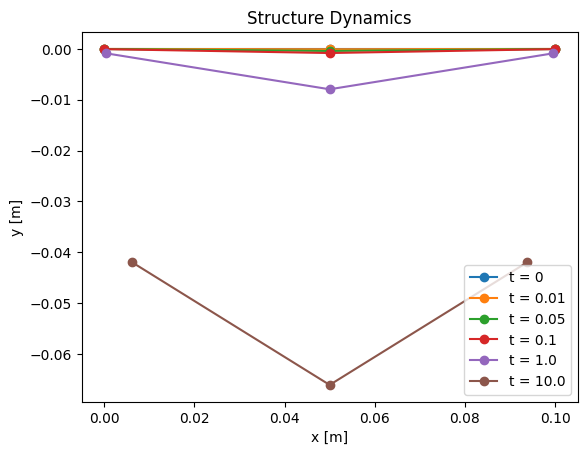

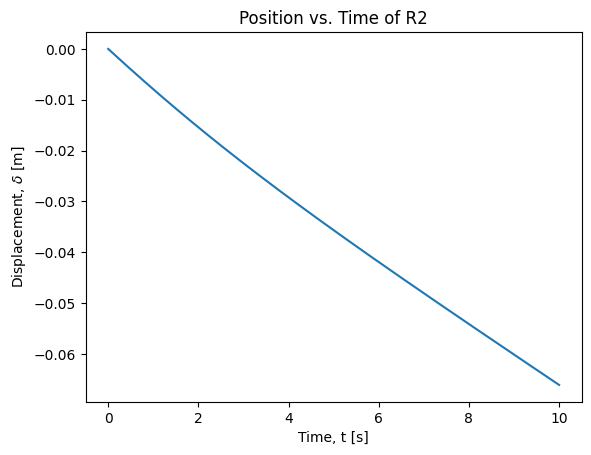

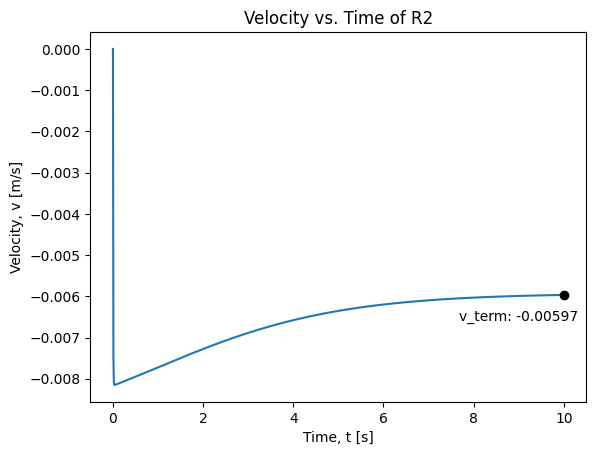

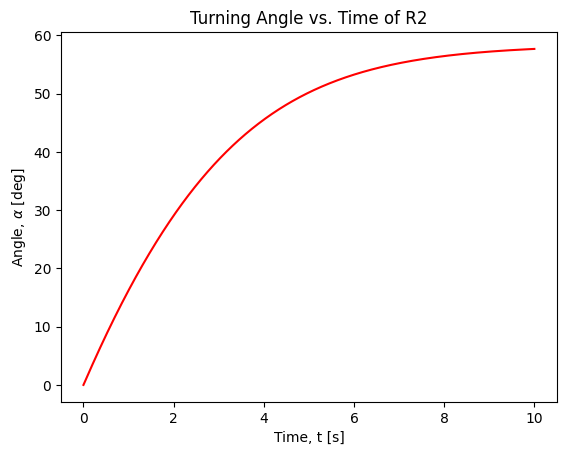

In [26]:
# Number of time steps
Nsteps = round(totalTime / dt)

ctime = 0
timesOfInterest = [0, 0.01, 0.05, 0.1, 1.0, 10.0]
valsOfInterest = np.zeros((2 * len(timesOfInterest), nv))
valsOfInterest[0] = q[0::2] # x0
valsOfInterest[1] = q[1::2] # y0
counter = 2

all_pos = np.zeros(Nsteps)
all_v = np.zeros(Nsteps)
midAngle = np.zeros(Nsteps)

for timeStep in range(1, Nsteps):  # Python uses 0-based indexing, hence range starts at 1
    # print(f't={ctime:.6f}')

    q, error = objfun(q0, q0, u, dt, tol, maximum_iter, m, mMat, EI, EA, W, C, deltaL)

    if error < 0:
        print('Could not converge. Sorry')
        break  # Exit the loop if convergence fails

    u = (q - q0) / dt  # velocity
    ctime += dt  # current time

    # Update q0
    q0 = q

    if any(math.isclose(ctime, i) for i in timesOfInterest[1:]):
      valsOfInterest[counter] = q[0::2]
      valsOfInterest[counter + 1] = q[1::2]
      counter += 2
    elif math.isclose(ctime, timesOfInterest[len(timesOfInterest) - 1] - 0.01): # exception to print at 10.0; stops at 9.99
      valsOfInterest[counter] = q[0::2]
      valsOfInterest[counter + 1] = q[1::2]

    '''
    if timeStep % plotStep == 0:
      x1 = q[0::2]  # Selects every second element starting from index 0
      x2 = q[1::2]  # Selects every second element starting from index 1
      h1 = plt.figure(1)
      plt.clf()  # Clear the current figure
      clear_output(wait=True)  # Clear the previous plot/output: Only for iPython
      plt.plot(x1, x2, 'ko-')  # 'ko-' indicates black color with circle markers and solid lines
      plt.title(f't={ctime:.6f}')  # Format the title with the current time
      plt.axis('equal')  # Set equal scaling
      plt.xlabel('x [m]')
      plt.ylabel('y [m]')
      plt.show()  # Display the figure
    '''

    all_pos[timeStep] = q[3]  # Python uses 0-based indexing
    all_v[timeStep] = u[3]

    # Angle at the center
    vec1 = np.array([q[2], q[3], 0]) - np.array([q[0], q[1], 0])
    vec2 = np.array([q[4], q[5], 0]) - np.array([q[2], q[3], 0])
    midAngle[timeStep] = np.degrees(np.arctan2(np.linalg.norm(np.cross(vec1, vec2)), np.dot(vec1, vec2)))

# Plot
plt.figure(2)
for i in range(0, len(timesOfInterest)):
  plt.plot(valsOfInterest[2 * i,:], valsOfInterest[2 * i + 1,:], 'o-', label=('t = ' + str(timesOfInterest[i])))
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.legend(loc='lower right') # legend
plt.title('Structure Dynamics')

plt.figure(4)
t = np.linspace(0, totalTime, Nsteps)
plt.plot(t, all_pos)
plt.xlabel('Time, t [s]')
plt.ylabel('Displacement, $\\delta$ [m]')
plt.title('Position vs. Time of R2')
#plt.savefig('fallingBeam.png')

plt.figure(5)
plt.plot(t, all_v)
plt.xlabel('Time, t [s]')
plt.ylabel('Velocity, v [m/s]')
plt.text(totalTime - 1, all_v[len(all_v) - 1] - 0.0007, 'v_term: ' + "{:.5f}".format(all_v[len(all_v) - 1]), ha='center', va='bottom')
plt.plot(totalTime, all_v[len(all_v) - 1], 'ko-')
plt.title('Velocity vs. Time of R2')
#plt.savefig('fallingBeam_velocity.png')

plt.figure(6)
plt.plot(t, midAngle, 'r')
plt.xlabel('Time, t [s]')
plt.ylabel('Angle, $\\alpha$ [deg]')
plt.title('Turning Angle vs. Time of R2')
#plt.savefig('fallingBeam_angle.png')

plt.show()